In [1]:
import numpy as np
from sklearn.cluster import DBSCAN

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
from osgeo import gdal, gdal_array

In [4]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [7]:
import pickle

Actually channel 2 is blue, not green. See https://github.com/apburnes/landsat8:
1 = violet; 2 = blue; 3 = green; 4 = red; 5 = NIR; 6 = midIR; 7 = far-ishIR... 10 = thermIR1, 11 = thermIR2

So the LANDSAT USGS ARD tiles are 2D 5000x5000 rasters. Location info is solely in the metadata and must include a starting point, resolution, and messier geometry / projection info.

## Check stacked geotiff from GRASS 7.8
Should have elevation and LANDSAT 8 OLI channels 1 to 7, in that order.

In [8]:
tile = gdal.Open('HI004002alldata.tif')
arr = tile.ReadAsArray()
arr.shape

(8, 2599, 2184)

In [9]:
arr = arr[:,2:,:]

In [10]:
arr[1,0:10,0]

array([186, 156, 156, 265, 292, 182, 150, 102,  71,  99], dtype=int16)

In [12]:
spatial = np.empty_like(arr[0:2,:,:])
spatial.shape

(2, 2597, 2184)

In [13]:
# dimension 0 will be latitude = row number
# dimension 1 will be longtitude = column number
for i in range(spatial.shape[1]):
    spatial[0,i,:].fill(i)
spatial[0,:10,:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]], dtype=int16)

In [14]:
for j in range(spatial.shape[2]):
    spatial[1,:,j].fill(j)
spatial[1,:10,:10]

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], dtype=int16)

In [15]:
fulldata = np.concatenate((spatial,arr),axis=0)
fulldata.shape

(10, 2597, 2184)

In [16]:
fulldata[:,0,0]

array([   0,    0, 2551,  186,  327,  606,  690, 2049, 1891, 1255],
      dtype=int16)

We now have an array with spatial coordinates x, y, and z, followed by seven spectral channels from borderline UV to mid IR. Now it's safe (in a sense) to unstack it into a zillion by 10 array to pass to the scaler.

In [19]:
X = fulldata.reshape(10,-1,order='C').T
print(X.shape,X[0,:])

(5671848, 10) [   0    0 2551  186  327  606  690 2049 1891 1255]


In [20]:
scaler = StandardScaler()
Xsc = scaler.fit_transform(X)

In [21]:
Xsamp = Xsc[np.random.choice(Xsc.shape[0],int(0.01*Xsc.shape[0]),replace=False)]

In [22]:
for p in np.arange(0.10,0.60,0.05):
    signal_cluster = DBSCAN(eps=p,min_samples=25,n_jobs=2).fit(Xsamp)
    core_samples_mask = np.zeros_like(signal_cluster.labels_, dtype=bool)
    core_samples_mask[signal_cluster.core_sample_indices_] = True
    labels = signal_cluster.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('DBSCAN results for scaled cluster distance %0.3f' % p)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f\n" % metrics.silhouette_score(Xsamp, labels))

DBSCAN results for scaled cluster distance 0.100
Estimated number of clusters: 6
Estimated number of noise points: 35194
Silhouette Coefficient: -0.205

DBSCAN results for scaled cluster distance 0.150
Estimated number of clusters: 19
Estimated number of noise points: 32591
Silhouette Coefficient: -0.304

DBSCAN results for scaled cluster distance 0.200
Estimated number of clusters: 15
Estimated number of noise points: 26054
Silhouette Coefficient: -0.178

DBSCAN results for scaled cluster distance 0.250
Estimated number of clusters: 26
Estimated number of noise points: 19948
Silhouette Coefficient: -0.167

DBSCAN results for scaled cluster distance 0.300
Estimated number of clusters: 23
Estimated number of noise points: 15364
Silhouette Coefficient: -0.177

DBSCAN results for scaled cluster distance 0.350
Estimated number of clusters: 19
Estimated number of noise points: 11630
Silhouette Coefficient: -0.186

DBSCAN results for scaled cluster distance 0.400
Estimated number of clusters

I am not at all sure I can get away with sampling for this purpose. I need the points to be contiguous, don't I?

I reread the clustering lecture notes and realized I should be gridsearching on n_core (number of neighbors required to nucleate a core) rather than leaving it at the default 5, although I expect that the distance is the more important hyperparameter.

In [23]:
Xss = Xsc[np.random.choice(Xsc.shape[0],int(0.005*Xsc.shape[0]), replace=False)]
Xss.shape

(28359, 10)

In [25]:
for p in np.arange(0.10,0.60,0.05):
    for n in [5,125]:
        signal_cluster = DBSCAN(eps=p,min_samples=n,n_jobs=2).fit(Xss)
        core_samples_mask = np.zeros_like(signal_cluster.labels_, dtype=bool)
        core_samples_mask[signal_cluster.core_sample_indices_] = True
        labels = signal_cluster.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print('DBSCAN results for scaled cluster distance %0.3f, core min %d' % (p,n))
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        try:
            print("Silhouette Coefficient: %0.3f\n" % metrics.silhouette_score(Xss, labels))
        except:
            print("No clusters found.\n")

DBSCAN results for scaled cluster distance 0.100, core min 5
Estimated number of clusters: 72
Estimated number of noise points: 16752
Silhouette Coefficient: -0.499

DBSCAN results for scaled cluster distance 0.100, core min 125
Estimated number of clusters: 0
Estimated number of noise points: 28359
No clusters found.
DBSCAN results for scaled cluster distance 0.150, core min 5
Estimated number of clusters: 191
Estimated number of noise points: 13192
Silhouette Coefficient: -0.448

DBSCAN results for scaled cluster distance 0.150, core min 125
Estimated number of clusters: 10
Estimated number of noise points: 22044
Silhouette Coefficient: -0.053

DBSCAN results for scaled cluster distance 0.200, core min 5
Estimated number of clusters: 147
Estimated number of noise points: 9522
Silhouette Coefficient: -0.425

DBSCAN results for scaled cluster distance 0.200, core min 125
Estimated number of clusters: 2
Estimated number of noise points: 17671
Silhouette Coefficient: 0.317

DBSCAN result

Mean shift is also conceivably worth trying.

In [26]:
defbandwidth = estimate_bandwidth(Xss)
defbandwidth

2.8550276750225576

In [27]:
for mul in np.arange(0.25,4.25,0.25):
    window = float(defbandwidth*mul)
    signal_cluster = MeanShift(bandwidth=window, bin_seeding=True,
                               cluster_all=False, n_jobs=2).fit(Xss)
    n_clusters_ = signal_cluster.cluster_centers_.shape[0]
    n_noise_ = list(signal_cluster.labels_).count(-1)
    print('Mean Shift results for window size %0.3f' % window)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    labelarray = np.concatenate((signal_cluster.labels_.reshape(-1,1),Xss),axis=1)
    clusterpoints = labelarray[labelarray[:,0]>-1]
    try:
        print("Silhouette Coefficient: %0.3f\n" % 
          metrics.silhouette_score(clusterpoints[:,1:], clusterpoints[:,0]))
    except:
            print("No clusters found.\n")

Mean Shift results for window size 0.714
Estimated number of clusters: 495
Estimated number of noise points: 13037
Silhouette Coefficient: 0.510

Mean Shift results for window size 1.428
Estimated number of clusters: 84
Estimated number of noise points: 10898
Silhouette Coefficient: 0.552

Mean Shift results for window size 2.141
Estimated number of clusters: 26
Estimated number of noise points: 7060
Silhouette Coefficient: 0.524

Mean Shift results for window size 2.855
Estimated number of clusters: 16
Estimated number of noise points: 8853
Silhouette Coefficient: 0.583

Mean Shift results for window size 3.569
Estimated number of clusters: 9
Estimated number of noise points: 2471
Silhouette Coefficient: 0.736

Mean Shift results for window size 4.283
Estimated number of clusters: 6
Estimated number of noise points: 1423
Silhouette Coefficient: 0.736

Mean Shift results for window size 4.996
Estimated number of clusters: 4
Estimated number of noise points: 1070
Silhouette Coefficient:

Should save some of these to examine.

In [28]:
signal_clusters = {}
for mul in np.arange(0.25,1.75,0.25):
    window = float(defbandwidth*mul)
    signal_clusters[mul] = MeanShift(bandwidth=window, bin_seeding=True,
                               cluster_all=False, n_jobs=2).fit(Xss)
    n_clusters_ = signal_clusters[mul].cluster_centers_.shape[0]
    n_noise_ = list(signal_clusters[mul].labels_).count(-1)
    print('Mean Shift results for window size %0.3f' % window)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    labelarray = np.concatenate((signal_clusters[mul].labels_.reshape(-1,1),Xss),axis=1)
    clusterpoints = labelarray[labelarray[:,0]>-1]
    print("Silhouette Coefficient: %0.3f\n" % 
          metrics.silhouette_score(clusterpoints[:,1:], clusterpoints[:,0]))

Mean Shift results for window size 0.714
Estimated number of clusters: 495
Estimated number of noise points: 13037
Silhouette Coefficient: 0.510

Mean Shift results for window size 1.428
Estimated number of clusters: 84
Estimated number of noise points: 10898
Silhouette Coefficient: 0.552

Mean Shift results for window size 2.141
Estimated number of clusters: 26
Estimated number of noise points: 7060
Silhouette Coefficient: 0.524

Mean Shift results for window size 2.855
Estimated number of clusters: 16
Estimated number of noise points: 8853
Silhouette Coefficient: 0.583

Mean Shift results for window size 3.569
Estimated number of clusters: 9
Estimated number of noise points: 2471
Silhouette Coefficient: 0.736

Mean Shift results for window size 4.283
Estimated number of clusters: 6
Estimated number of noise points: 1423
Silhouette Coefficient: 0.736



There are some feasible clusters there, but we'll see. Next steps:

* Make histograms over each of these distributions. Check whether they are somewhat reasonably balanced.
* If any of them are, then set up those distributions for plotting. This will require:
    * x, y coordinates of point
    * cluster label for each point
    * color assignments for each cluster, which will require
    * colors calculated from landPCA projection of cluster centroids and turned into hex codes or whatever seaborn wants

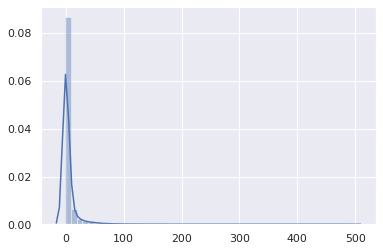

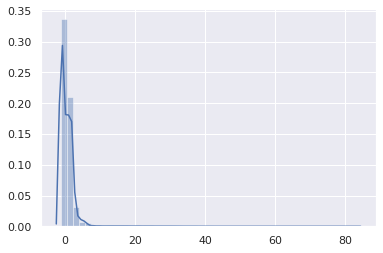

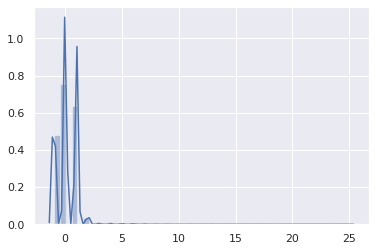

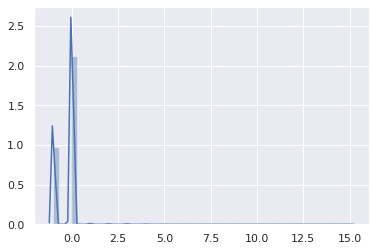

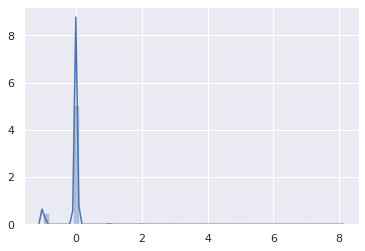

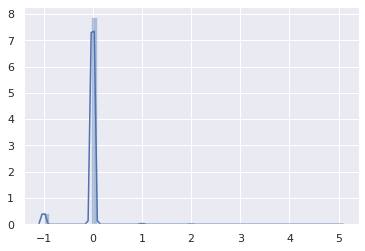

In [31]:
import
for key in signal_clusters.keys():
    labels = pd
    sns.countplot(np.ravel(signal_clusters[key].labels_))
    plt.show();

All right, that brings us to damage control. I want to change the scale on the spatial and spectral data so that one is more important than the other, but I'm fuzzy on what shrinking one as opposed to the other would do. If I shrink the spatial dimensions, then they count less for distance and the clustering algorithm will try to separate everything spectrally, right? So I want to shrink the spectral dimensions? In any case, I can try both.

In [32]:
# shrink spectral dimensions
print(Xss[0,:])
Xss[:,3:10]=Xss[:,3:10]/10.0
Xss[0,:]

[ 1.44726628 -0.61303819 -0.77888362  0.71392904  0.27565109 -0.57070546
 -0.55091936 -0.96911189 -0.94811005 -0.81358652]


array([ 1.44726628, -0.61303819, -0.77888362,  0.0713929 ,  0.02756511,
       -0.05707055, -0.05509194, -0.09691119, -0.09481101, -0.08135865])

In [33]:
dbclusters={}
for p in np.arange(0.10,0.60,0.05):
    for n in [5,25,125]:
        dbclusters[(p,n)] = DBSCAN(eps=p,min_samples=n,n_jobs=2).fit(Xss)
        core_samples_mask = np.zeros_like(dbclusters[(p,n)].labels_, dtype=bool)
        core_samples_mask[dbclusters[(p,n)].core_sample_indices_] = True
        labels = dbclusters[(p,n)].labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print('DBSCAN results for scaled cluster distance %0.3f, core min %d' % (p,n))
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        try:
            print("Silhouette Coefficient: %0.3f\n" % metrics.silhouette_score(Xss, labels))
        except:
            print("No clusters found.\n")

DBSCAN results for scaled cluster distance 0.100, core min 5
Estimated number of clusters: 56
Estimated number of noise points: 1926
Silhouette Coefficient: -0.652

DBSCAN results for scaled cluster distance 0.100, core min 25
Estimated number of clusters: 34
Estimated number of noise points: 8899
Silhouette Coefficient: -0.490

DBSCAN results for scaled cluster distance 0.100, core min 125
Estimated number of clusters: 0
Estimated number of noise points: 28359
No clusters found.

DBSCAN results for scaled cluster distance 0.150, core min 5
Estimated number of clusters: 2
Estimated number of noise points: 635
Silhouette Coefficient: -0.196

DBSCAN results for scaled cluster distance 0.150, core min 25
Estimated number of clusters: 7
Estimated number of noise points: 2155
Silhouette Coefficient: -0.084

DBSCAN results for scaled cluster distance 0.150, core min 125
Estimated number of clusters: 4
Estimated number of noise points: 16777
Silhouette Coefficient: -0.115

DBSCAN results for 

In [35]:
msclusters = {}
for mul in np.arange(0.25,1.75,0.25):
    window = float(defbandwidth*mul)
    msclusters[mul] = MeanShift(bandwidth=window, bin_seeding=True,
                               cluster_all=False, n_jobs=2).fit(Xss)
    n_clusters_ = msclusters[mul].cluster_centers_.shape[0]
    n_noise_ = list(msclusters[mul].labels_).count(-1)
    print('Mean Shift results for window size %0.3f' % window)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    labelarray = np.concatenate((msclusters[mul].labels_.reshape(-1,1),Xss),axis=1)
    clusterpoints = labelarray[labelarray[:,0]>-1]
    try:
        print("Silhouette Coefficient: %0.3f\n" % 
              metrics.silhouette_score(clusterpoints[:,1:], clusterpoints[:,0]))
    except:
        print("No clusters found.\n")

Mean Shift results for window size 0.714
Estimated number of clusters: 16
Estimated number of noise points: 13388
Silhouette Coefficient: 0.457

Mean Shift results for window size 1.428
Estimated number of clusters: 2
Estimated number of noise points: 10559
Silhouette Coefficient: 0.447

Mean Shift results for window size 2.141
Estimated number of clusters: 1
Estimated number of noise points: 5977
No clusters found.

Mean Shift results for window size 2.855
Estimated number of clusters: 1
Estimated number of noise points: 1494
No clusters found.

Mean Shift results for window size 3.569
Estimated number of clusters: 1
Estimated number of noise points: 278
No clusters found.

Mean Shift results for window size 4.283
Estimated number of clusters: 1
Estimated number of noise points: 38
No clusters found.



In [36]:
# shrink spatial dimensions
Xss[:,3:10]=Xss[:,3:10]*10.0
Xss[:,0:3]=Xss[:,0:3]/10.0
Xss[0,:]

array([ 0.14472663, -0.06130382, -0.07788836,  0.71392904,  0.27565109,
       -0.57070546, -0.55091936, -0.96911189, -0.94811005, -0.81358652])

In [37]:
dbflips={}
for p in np.arange(0.10,0.60,0.05):
    for n in [5,25,125]:
        dbflips[(p,n)] = DBSCAN(eps=p,min_samples=n,n_jobs=2).fit(Xss)
        core_samples_mask = np.zeros_like(dbflips[(p,n)].labels_, dtype=bool)
        core_samples_mask[dbflips[(p,n)].core_sample_indices_] = True
        labels = dbflips[(p,n)].labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print('DBSCAN results for scaled cluster distance %0.3f, core min %d' % (p,n))
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        try:
            print("Silhouette Coefficient: %0.3f\n" % metrics.silhouette_score(Xss, labels))
        except:
            print("No clusters found.\n")

DBSCAN results for scaled cluster distance 0.100, core min 5
Estimated number of clusters: 115
Estimated number of noise points: 12135
Silhouette Coefficient: -0.320

DBSCAN results for scaled cluster distance 0.100, core min 25
Estimated number of clusters: 11
Estimated number of noise points: 16421
Silhouette Coefficient: -0.014

DBSCAN results for scaled cluster distance 0.100, core min 125
Estimated number of clusters: 1
Estimated number of noise points: 17653
Silhouette Coefficient: 0.461

DBSCAN results for scaled cluster distance 0.150, core min 5
Estimated number of clusters: 98
Estimated number of noise points: 7530
Silhouette Coefficient: -0.086

DBSCAN results for scaled cluster distance 0.150, core min 25
Estimated number of clusters: 8
Estimated number of noise points: 11708
Silhouette Coefficient: 0.083

DBSCAN results for scaled cluster distance 0.150, core min 125
Estimated number of clusters: 3
Estimated number of noise points: 16741
Silhouette Coefficient: 0.128

DBSC

In [47]:
msflips = {}
for mul in np.arange(0.25,3.75,0.25):
    window = float(defbandwidth*mul)
    msflips[mul] = MeanShift(bandwidth=window, bin_seeding=True,
                               cluster_all=False, n_jobs=2).fit(Xss)
    n_clusters_ = msflips[mul].cluster_centers_.shape[0]
    n_noise_ = list(msflips[mul].labels_).count(-1)
    print('Mean Shift results for window size %0.3f' % window)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    labelarray = np.concatenate((msflips[mul].labels_.reshape(-1,1),Xss),axis=1)
    clusterpoints = labelarray[labelarray[:,0]>-1]
    try:
        print("Silhouette Coefficient: %0.3f\n" % 
              metrics.silhouette_score(clusterpoints[:,1:], clusterpoints[:,0]))
    except:
        print("No clusters found.\n")

Mean Shift results for window size 0.714
Estimated number of clusters: 495
Estimated number of noise points: 13037
Silhouette Coefficient: 0.510

Mean Shift results for window size 1.428
Estimated number of clusters: 84
Estimated number of noise points: 10898
Silhouette Coefficient: 0.552

Mean Shift results for window size 2.141
Estimated number of clusters: 26
Estimated number of noise points: 7060
Silhouette Coefficient: 0.524

Mean Shift results for window size 2.855
Estimated number of clusters: 16
Estimated number of noise points: 8853
Silhouette Coefficient: 0.583

Mean Shift results for window size 3.569
Estimated number of clusters: 9
Estimated number of noise points: 2471
Silhouette Coefficient: 0.736

Mean Shift results for window size 4.283
Estimated number of clusters: 6
Estimated number of noise points: 1423
Silhouette Coefficient: 0.736

Mean Shift results for window size 4.996
Estimated number of clusters: 4
Estimated number of noise points: 1070
Silhouette Coefficient:

In [49]:
dbflips

{(0.1,
  5): DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
        metric_params=None, min_samples=5, n_jobs=2, p=None),
 (0.1,
  25): DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
        metric_params=None, min_samples=25, n_jobs=2, p=None),
 (0.1,
  125): DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
        metric_params=None, min_samples=125, n_jobs=2, p=None),
 (0.15000000000000002,
  5): DBSCAN(algorithm='auto', eps=0.15000000000000002, leaf_size=30,
        metric='euclidean', metric_params=None, min_samples=5, n_jobs=2, p=None),
 (0.15000000000000002,
  25): DBSCAN(algorithm='auto', eps=0.15000000000000002, leaf_size=30,
        metric='euclidean', metric_params=None, min_samples=25, n_jobs=2,
        p=None),
 (0.15000000000000002,
  125): DBSCAN(algorithm='auto', eps=0.15000000000000002, leaf_size=30,
        metric='euclidean', metric_params=None, min_samples=125, n_jobs=2,
        p=None),
 (0.20000000000000

Promising clustering results:
`dbclusters`... not a damned thing.
`msclusters[0.25]`
`dbflips[(0.4,5),(0.55,5)]`... Ooops. Fukit. I meant `(0.4,25)`
`msflips[0.5,0.75,1.0,1.25,1.5]`

<class 'matplotlib.axes._subplots.AxesSubplot'>


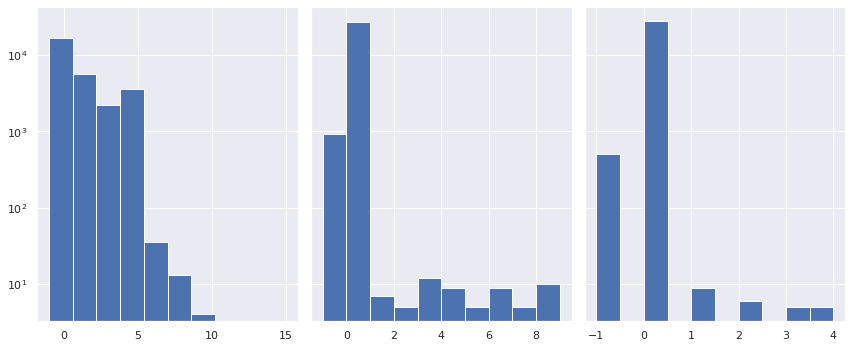

In [65]:
targets = [msclusters[0.25],dbflips[(0.40000000000000013,5)],dbflips[(0.5500000000000002,5)]]
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(12,5))
print(type(axs[0]))
for i, model in enumerate(targets):
    axs[i].hist(np.ravel(model.labels_), log=True)

In [53]:
len(msflips.keys())

14

(2, 7)


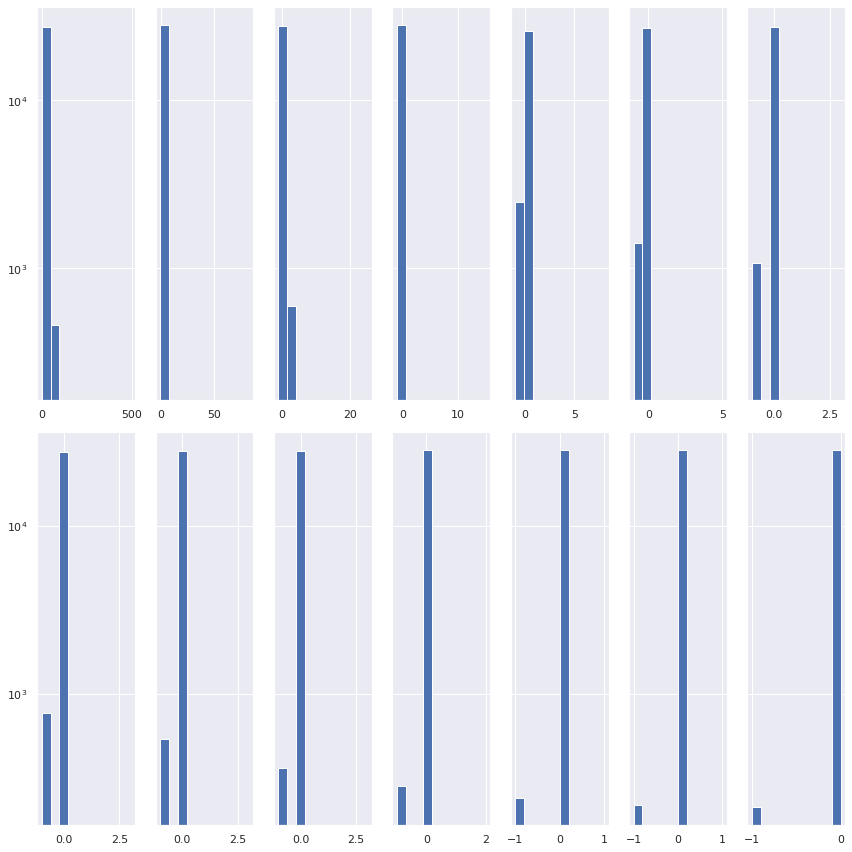

In [70]:
#fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(12,5))
#for i, model in enumerate(targets):
#    axs[i].hist(np.ravel(model.labels_), log=True)

fig, axs = plt.subplots(2, 7, sharey=True, tight_layout=True, figsize=(12,12))
print(axs.shape)
for i, key in enumerate(msflips.keys()):
    if i < 7:
        axs[0,i].hist(np.ravel(msflips[key].labels_), log=True)
    else:
        axs[1,i-7].hist(np.ravel(msflips[key].labels_), log=True)

Let's plot the first three. I was worried about getting the centroid color calibrated to mean something, but for right now there are only a dozen cluster-objects at most, so I won't exhaust a color palette nor my ability to think through what the randomly colored objects are.

Except seaborn vomited all over itself. Hmmm. Can I somehow create a sparse matrix and convert it to a raster? Not with scipy.sparse.coo_matrix, that's choking on its own vomit too.

In [89]:
Xss[:,0:3]=Xss[:,0:3]*10.0

In [92]:
Xss[:,0:3]=Xss[:,0:3]/10.0
Xss

array([[ 1.44726628, -0.61303819, -0.77888362, ..., -0.96911189,
        -0.94811005, -0.81358652],
       [-1.24051395, -0.64476074,  0.65503945, ...,  1.54058539,
         0.78140908,  0.27408151],
       [-0.56556765, -1.05239545,  1.19993022, ..., -0.17731219,
         1.07845921,  1.24507242],
       ...,
       [-0.17340518,  1.18245789, -0.77888362, ..., -0.93134053,
        -0.92478794, -0.79974348],
       [-0.63226195, -1.35693189,  1.71108162, ...,  0.09268311,
         0.47331164,  0.34329674],
       [-0.13872414,  1.49968334, -0.77888362, ..., -0.95792037,
        -0.93338029, -0.78985559]])

In [93]:
Cs=[]
Xxy = scaler.inverse_transform(Xss)
for model in enumerate(targets):
    Cs.append(np.concatenate(((model.labels_).reshape(-1,1),Xxy[:,0:2].astype(int)),axis=1))

In [95]:
rasarrays = []
for matrix in Cs:
    # for now just making a grayscale array
    rasarrays.append(np.zeros(arr[0,:,:]))
    for i in range(matrix.shape[0]):
        

TypeError: only integer scalar arrays can be converted to a scalar index

In [42]:
print(np.min(X), np.max(X))

-2000 16604


Right, I scaled `X` to make `Xsc`.

In [43]:
pca3 = PCA(n_components=3)
signal3 = pca3.fit_transform(Xsc)
print(pca3.components_)
print(pca3.explained_variance_ratio_)

[[-0.05278744 -0.20105742  0.20146306  0.18054106  0.27917228  0.42914731
   0.42803077  0.30032465  0.40318585  0.43074159]
 [ 0.22201521  0.34464573 -0.4248821   0.53324727  0.45708589  0.1397536
   0.14058989 -0.28873299 -0.18444937 -0.03793032]
 [-0.68845062  0.54191344 -0.3125506  -0.04899759 -0.04264367  0.05200009
  -0.06427725  0.3234295   0.13611875  0.02208869]]
[0.50008597 0.27260612 0.10978259]


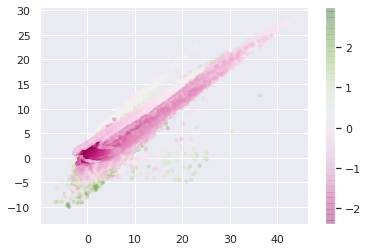

In [44]:
f, ax = plt.subplots()
points = ax.scatter(signal3[:,0], signal3[:,1], c=signal3[:,2], s=10, cmap='PiYG', alpha=0.2)
f.colorbar(points)
plt.show();

I should...try clustering these by...cosine distance? At first blush it looks like PCA has gotten this wrong, just like all the other times, and the true principal axis is about y = 5/8 x, but apparently the noisy points at the bottom right justify this? Still, it might be interesting to try "flattening" the data in that direction. Then I had a better idea... let's first look at plots on the other faces of this orthorhombic lattice.

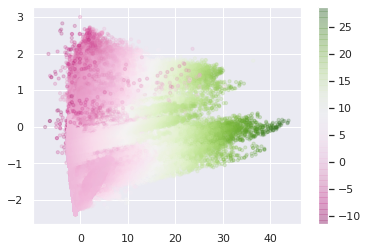

In [45]:
f, ax = plt.subplots()
points = ax.scatter(signal3[:,0], signal3[:,2], c=signal3[:,1], s=10, cmap='PiYG', alpha=0.2)
f.colorbar(points)
plt.show();

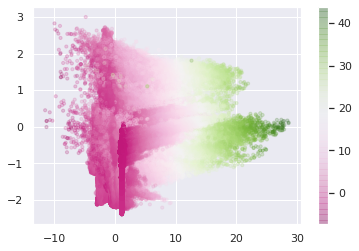

In [46]:
f, ax = plt.subplots()
points = ax.scatter(signal3[:,1], signal3[:,2], c=signal3[:,0], s=10, cmap='PiYG', alpha=0.2)
f.colorbar(points)
plt.show();

In [103]:
clustermaps = {}
for i, key in enumerate(signal_clusters.keys()):
    clustermaps[i] = np.concatenate((signal_clusters[key].))

In [109]:
centroids = landpca3.transform(signal_cluster.cluster_centers_)

In [110]:
labels = (np.array(np.arange(4))).reshape(4,1)
labels

array([[0],
       [1],
       [2],
       [3]])

In [111]:
centroid_label = np.concatenate((labels,centroids),axis=1)
centroid_label

array([[ 0.00000000e+00, -2.65483939e-01,  2.05806341e-03,
        -1.58237190e-03],
       [ 1.00000000e+00,  2.43647596e+01, -2.41524704e+00,
         2.61205740e+00],
       [ 2.00000000e+00,  4.83216579e+01, -4.20991565e+00,
         6.57663750e+00],
       [ 3.00000000e+00,  3.41941141e+00,  5.42933475e+00,
        -3.54018951e+00]])

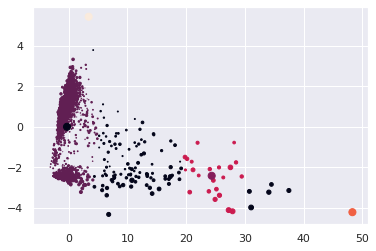

In [113]:
f, ax = plt.subplots()
points = ax.scatter(labelpca3[:,1], labelpca3[:,2], 
                    s=labelpca3[:,3]*5, c=labelpca3[:,0])
centers = ax.scatter(centroid_label[:,1], centroid_label[:,2], 
                    s=50, c=centroid_label[:,0])
plt.show();

In [114]:
sig_clusts=[]
for mul in np.arange(2.25,3.25,0.25):
    window = float(defbandwidth*mul)
    sig_clusts.append(MeanShift(bandwidth=window, bin_seeding=True,
                               cluster_all=False, n_jobs=2).fit(Xs))
    n_clusters_ = sig_clusts[-1].cluster_centers_.shape[0]
    n_noise_ = list(sig_clusts[-1].labels_).count(-1)
    print('Mean Shift results for window size %0.3f' % window)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    labelarray = np.concatenate((sig_clusts[-1].labels_.reshape(-1,1),Xs),axis=1)
    clusterpoints = labelarray[labelarray[:,0]>-1]
    print("Silhouette Coefficient: %0.3f\n" % 
      metrics.silhouette_score(clusterpoints[:,1:], clusterpoints[:,0]))

Mean Shift results for window size 3.939
Estimated number of clusters: 7
Estimated number of noise points: 418
Silhouette Coefficient: 0.700

Mean Shift results for window size 4.376
Estimated number of clusters: 6
Estimated number of noise points: 373
Silhouette Coefficient: 0.696

Mean Shift results for window size 4.814
Estimated number of clusters: 5
Estimated number of noise points: 302
Silhouette Coefficient: 0.691

Mean Shift results for window size 5.252
Estimated number of clusters: 4
Estimated number of noise points: 242
Silhouette Coefficient: 0.766



In [119]:
cents = []
for ms in sig_clusts:
    cnum = []
    cents.append(landpca3.transform(ms.cluster_centers_))
    labels = (np.array(np.arange(ms.cluster_centers_.shape[0]))).reshape(-1,1)
    for label in labels:
        cnum.append(list(ms.labels_).count(label))
    cnum = (np.array(cnum)).reshape(-1,1)
    cents[-1] = np.concatenate((labels,cents[-1],cnum),axis=1)

In [120]:
cents[2]

array([[ 0.00000000e+00, -2.91996444e-01, -5.86079051e-03,
         5.35566406e-03,  9.51900000e+03],
       [ 1.00000000e+00,  2.69426102e+01, -2.80333043e+00,
         3.01633372e+00,  1.60000000e+01],
       [ 2.00000000e+00, -3.28528997e+00,  1.17558864e+00,
        -4.07077339e+00,  2.00000000e+00],
       [ 3.00000000e+00,  4.83216579e+01, -4.20991565e+00,
         6.57663750e+00,  1.00000000e+00],
       [ 4.00000000e+00,  3.41941141e+00,  5.42933475e+00,
        -3.54018951e+00,  1.00000000e+00]])

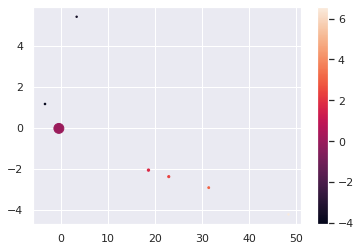

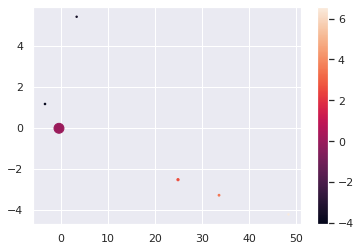

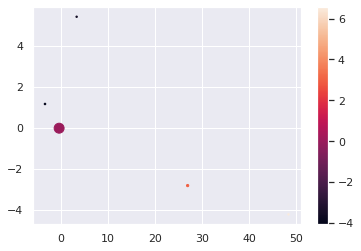

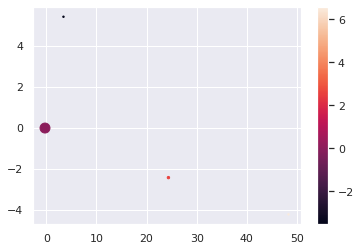

In [122]:
for centroids in cents:
    f, ax = plt.subplots()
    centers = ax.scatter(centroids[:,1], centroids[:,2], 
                        s=1+np.sqrt(centroids[:,4]), c=centroids[:,3])
    f.colorbar(centers)
    plt.show();

In [123]:
cents

[array([[ 0.00000000e+00, -3.47725425e-01, -1.55562596e-02,
          1.40683241e-02,  9.38200000e+03],
        [ 1.00000000e+00,  1.86441253e+01, -2.04876922e+00,
          1.79043639e+00,  1.90000000e+01],
        [ 2.00000000e+00,  2.29452005e+01, -2.36754997e+00,
          2.35821793e+00,  1.20000000e+01],
        [ 3.00000000e+00,  3.14133107e+01, -2.90501085e+00,
          3.08448885e+00,  6.00000000e+00],
        [ 4.00000000e+00, -3.28528997e+00,  1.17558864e+00,
         -4.07077339e+00,  2.00000000e+00],
        [ 5.00000000e+00,  4.83216579e+01, -4.20991565e+00,
          6.57663750e+00,  1.00000000e+00],
        [ 6.00000000e+00,  3.41941141e+00,  5.42933475e+00,
         -3.54018951e+00,  1.00000000e+00]]),
 array([[ 0.00000000e+00, -3.23685118e-01, -1.04239735e-02,
          9.68755863e-03,  9.44300000e+03],
        [ 1.00000000e+00,  2.49037574e+01, -2.51666734e+00,
          2.64414261e+00,  1.60000000e+01],
        [ 2.00000000e+00,  3.35995758e+01, -3.27339543e+00,
  